In [1]:
import numpy as np
import matplotlib.pyplot as plt
import EPPE_Simulator as eppe
import astropy.constants as const

In [250]:
expTime = 5
intTime = 30*24.

stellarVariability = False
randomOrientation = False
albedo = 'theo'
polEff = 1.
filt = 'V'

highPassSize = 20

savePlots = False

In [3]:
systems = eppe.Systems(load=True, polEff=polEff, randomOrientation=randomOrientation, albedo=albedo)

# mission = eppe.mission(systems, rad=0.8, filt=filt) # POMM
mission = eppe.mission(systems, filt=filt, trans=0.9) # EPPE

In [251]:
systems.updateAlbedos(mission.filterObj)

In [252]:
stokesCurves = mission.observe_polarization(expTime, intTime, stellarVariability=stellarVariability)
stokesCurves_ideal = mission.observe_polarization(expTime, intTime, photonNoise=False, pStart=0)
_, fstars, _, _ = mission.observe_photometric(expTime, intTime, photonNoise=True, pStart=0)

In [253]:
# i = 1
# i = systems.name_to_index('WASP-12 b')
# i = systems.name_to_index('HD 189733 b')
# i = systems.name_to_index('HD 209458 b')
# i = systems.name_to_index('KELT-7 b')
# i = systems.name_to_index('KELT-9 b')
i = systems.name_to_index('tau Boo b')
# i = systems.name_to_index('ups And b')
# i = systems.name_to_index('GJ 3323 b')

systems.index_details(i)

Name: tau Boo b
Radius: 1.14 Rjup
Period: 3.31 days
Equilibrium Temperature: 1685 K
Transit Depth: 0.644%
Distance: 16 pc


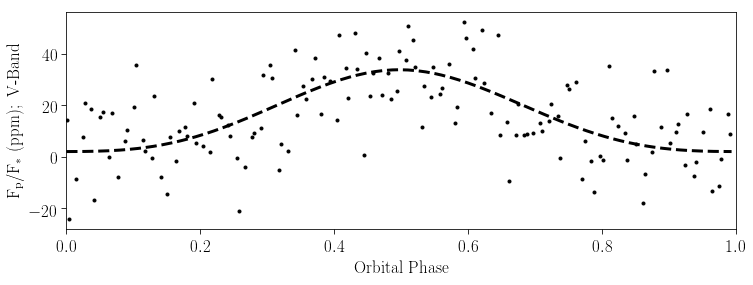

In [254]:
fig = eppe.plot_lightcurve(stokesCurves[i], filt, fstars[i], stokesCurve_ideal=stokesCurves_ideal[i], lines=True)

if savePlots:
    fname = 'saves/'+'_'.join(systems.catalogue['name'][i].split(' '))+'_lightcurve'
    if stellarVariability:
        fname += '_stellarVariability'
    if albedo=='theo':
        fname += '_theoAg'
    fname += '.png'
    fig.savefig(fname, dpi=300, bbox_inches='tight')
plt.show(fig)

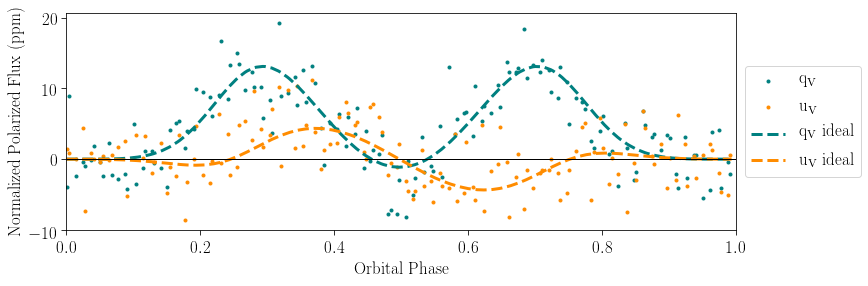

In [255]:
fig = eppe.plot_QU(stokesCurves[i], filt, normed=True, stokesCurve_ideal=stokesCurves_ideal[i], lines=True)#, highPassSize=highPassSize)

if savePlots:
    fname = 'saves/'+'_'.join(systems.catalogue['name'][i].split(' '))+'_QUcurve'
    if stellarVariability:
        fname += '_stellarVariability'
    if albedo=='theo':
        fname += '_theoAg'
    fname += '.png'
    fig.savefig(fname, dpi=300, bbox_inches='tight')
plt.show(fig)

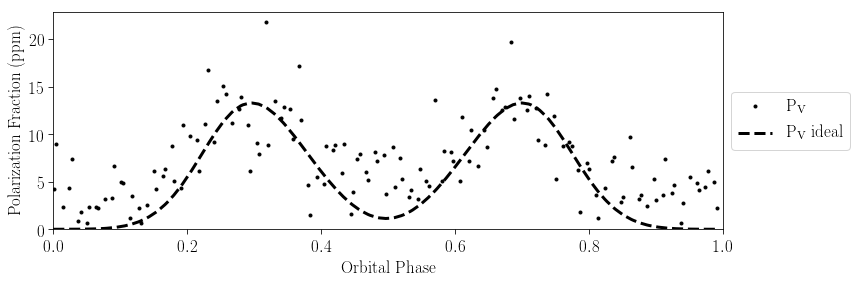

In [256]:
fig = eppe.plot_P(stokesCurves[i], filt, stokesCurve_ideal=stokesCurves_ideal[i], lines=True)

if savePlots:
    fname = 'saves/'+'_'.join(systems.catalogue['name'][i].split(' '))+'_Pcurve'
    if stellarVariability:
        fname += '_stellarVariability'
    if albedo=='theo':
        fname += '_theoAg'
    fname += '.png'
    fig.savefig(fname, dpi=300, bbox_inches='tight')
plt.show(fig)

In [111]:
import copy

In [141]:
import emcee

In [143]:
import time as t

In [257]:
fitSystem = copy.deepcopy(systems)
for key in tempSystem.catalogue.keys():
    fitSystem.catalogue[key] = np.array([systems.catalogue[key][i]])
    
fitMission = eppe.EPPE(fitSystem, filt=filt, trans=0.9) # EPPE

In [277]:
def lnlike(p0, q, u, fitMission, pStart, expTime, intTime):
    albedo, ang, sigma = p0
    sigma = 10**sigma
    
    if albedo < -1 or albedo > 2 or np.abs(ang)>180 or sigma < 0 or sigma > 1e-4:
        return -np.inf
    
    fitMission.systems.catalogue['albedo'] = np.array([albedo])
    fitMission.systems.catalogue['orbAxisAng'] = np.array([ang])
    
    modelCurve = fitMission.observe_polarization(expTime, intTime, photonNoise=False, pStart=pStart)[0]
    qModel = modelCurve[1]/modelCurve[0]
    uModel = modelCurve[2]/modelCurve[0]
    
#     order = np.argsort(modelCurve[-1])
#     plt.plot(modelCurve[-1], q, '.', c='blue')
#     plt.fill_between(modelCurve[-1][order], qModel[order]-sigma, qModel[order]+sigma, color='blue', alpha=0.2)
# #     plt.plot(modelCurve[-1], qModel, c='blue')
    
#     plt.plot(modelCurve[-1], u, '.', c='red')
#     plt.plot(modelCurve[-1], uModel, c='red')
    
#     plt.show()
#     plt.close()
    
    inv_sigma = 1/sigma
    
    Qlnl = -0.5*np.sum((q-qModel)**2)*inv_sigma**2 + q.size*np.log(inv_sigma)
    Ulnl = -0.5*np.sum((u-uModel)**2)*inv_sigma**2 + u.size*np.log(inv_sigma)
    
    return Qlnl+Ulnl

In [278]:
def walk_style(ndim, nwalk, samples, interv, subsamp, labels, fname=None):
    '''
    input:
        ndim    = number of free parameters
        nwalk   = number of walkers
        samples = samples chain
        interv  = take every 'interv' element to thin out the plot
        subsamp = only show the last 'subsamp' steps
    '''
    # get first index
    beg   = len(samples[0,:,0]) - subsamp
    end   = len(samples[0,:,0]) 
    step  = np.arange(beg,end)
    step  = step[::interv] 
    
    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows
    
    # plotting
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        mu_param = np.mean(samples[:,:,ind][:,beg:end:interv], axis = 0)
        std_param = np.std(samples[:,:,ind][:,beg:end:interv], axis = 0)
        plt.plot(step, mu_param)
        plt.fill_between(step, mu_param + 3*std_param, mu_param - 3*std_param, facecolor='k', alpha = 0.1)
        plt.fill_between(step, mu_param + 2*std_param, mu_param - 2*std_param, facecolor='k', alpha = 0.1)
        plt.fill_between(step, mu_param + 1*std_param, mu_param - 1*std_param, facecolor='k', alpha = 0.1)
        plt.title(labels[ind])
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else: 
            plt.xticks(rotation=25)
    if fname != None:
        plt.savefig(fname, bbox_inches='tight')
    else:
        plt.show()
    return    

In [279]:
# p = np.sqrt(stokesCurves[i][1]**2+stokesCurves[i][2]**2)/stokesCurves[i][0]
q = stokesCurves[i][1]/stokesCurves[i][0]
u = stokesCurves[i][2]/stokesCurves[i][0]
pStart=stokesCurves[i][-1][0]

In [294]:
p0 = np.array([systems.catalogue['albedo'][i], systems.catalogue['orbAxisAng'][i], np.log10(np.std(q)/3)])

In [295]:
lnlike(p0, q, u, fitMission, pStart, expTime, intTime)

3323.4717198725184

In [263]:
nwalkers = 100
ndim = 3
nBurninSteps = 1e4
nProductionSteps = 1e4

In [264]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, a = 2,
                                args=(q, u, fitMission, pStart, expTime, intTime))

In [265]:
pos0 = [p0*(1+1e-5*np.random.randn(ndim))+1e-5*np.abs(np.random.randn(ndim)) for i in range(nwalkers)]

In [266]:
pos0 = np.array(pos0)*np.array([1,1e5,1])

In [267]:
#Burn-in
#Start from true values, and do burn-in to get walkers spread out
tic = t.time()
print('Running burn-in')
sampler.reset()
pos1, prob, state = sampler.run_mcmc(pos0, np.rint(nBurninSteps/nwalkers))
print("Mean burn-in acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))
# sampler.reset()
toc = t.time()
print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))

Running burn-in
Mean burn-in acceptance fraction: 0.612
MCMC runtime = 5.33 min



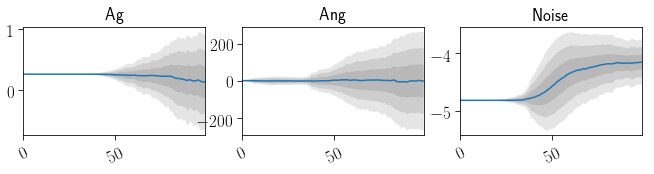

In [268]:
walk_style(ndim, nwalkers, sampler.chain, 1, sampler.chain.shape[-2], labels=['Ag', 'Ang', 'Noise'])

In [270]:
pathchain = 'saves/samplerchain.npy'
pathposit = 'saves/samplerposi.npy'
pathlnpro = 'saves/samplerlnpr.npy'
np.save(pathchain, sampler.chain)
np.save(pathposit, pos1)
np.save(pathlnpro, prob)

In [239]:
#Run production
#Run that will be saved
tic = t.time()
# Continue from last positions and run production
print('Running production')
sampler.reset()
pos3, prob, state = sampler.run_mcmc(pos1, np.rint(nProductionSteps/nwalkers))
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))
toc = t.time()
print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))

Running production
Mean acceptance fraction: 0.442
MCMC runtime = 4.55 min



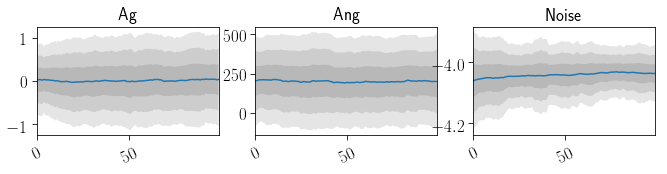

In [240]:
walk_style(ndim, nwalkers, sampler.chain, 1, sampler.chain.shape[-2], labels=['Ag', 'Ang', 'Noise'])